In [1]:
import os
# Ignore my broken HDF5 install...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

In [2]:
import pandas as pd
import cis
import iris

from utils import get_aeronet_data, get_bc_ppe_data

from GCEm.utils import validation_plot, plot_parameter_space, get_random_params, ensemble_collocate
from GCEm import gp_model
from GCEm.abc_sampler import ABCSampler, constrain

import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline


C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# Read in the parameters and observables

In [3]:
aaod = get_aeronet_data()
print(aaod)

Ungridded data: Absorption_AOD440nm / (1) 
     Shape = (10098,)

     Total number of points = 10098
     Number of non-masked points = 10098
     Long name = Absorption_AOD440nm
     Standard name = None
     Units = 1
     Missing value = -999.0
     Range = (5.1e-05, 0.47236)
     History = 
     Coordinates: 
       longitude
          Long name = 
          Standard name = longitude
          Units = degrees_east
          Missing value = None
          Range = (-155.576755, 141.3407)
          History = 
       latitude
          Long name = 
          Standard name = latitude
          Units = degrees_north
          Missing value = None
          Range = (-35.495807, 79.990278)
          History = 
       time
          Long name = 
          Standard name = time
          Units = days since 1600-01-01 00:00:00
          Missing value = None
          Range = (cftime.DatetimeGregorian(2017, 1, 1, 12, 0, 0, 0), cftime.DatetimeGregorian(2018, 1, 2, 12, 0, 0, 0))
          Histor

In [4]:
# Read in the PPE parameters, AAOD and DRE
ppe_params, ppe_aaod, ppe_dre = get_bc_ppe_data(dre=True)

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated a

In [5]:
# Take the annual mean of the DRE
ppe_dre, = ppe_dre.collapsed('time', iris.analysis.MEAN)

# Collocate the model on to the observations

In [6]:
col_ppe_aaod = ensemble_collocate(ppe_aaod, aaod)

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\numpy\ma\core.py:3225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\numpy\ma\core.py:3225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\numpy\ma\core.py:3225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

In [7]:
n_test = 8

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
Y_test, Y_train = col_ppe_aaod[:n_test], col_ppe_aaod[n_test:]

In [8]:
Y_train

Absorption Optical Thickness - Total 550Nm (1),job,obs
Shape,31,10098
Dimension coordinates,,
job,x,-
obs,-,x
Auxiliary coordinates,,
latitude,-,x
longitude,-,x
time,-,x


# Setup and run the models

In [9]:
model = gp_model(X_train, Y_train)

In [10]:
model.train()

In [11]:
m, v = model.predict(X_test.values)

Proportion of 'Bad' estimates : 0.86%


C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


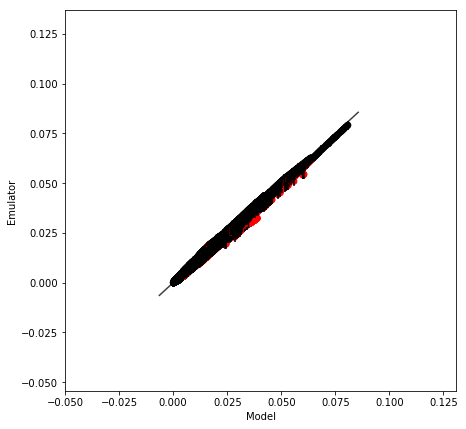

In [12]:
validation_plot(Y_test.data.flatten(), m.data.flatten(), v.data.flatten())

# Sample and constrain the models

Emulating 1e6 sample points directly would require 673 Gb of memory so we can either run 1e6 samples for each point, or run the constraint everywhere, but in batches. Here we do the latter, optioanlly on the GPU, using the 'naive' algorithm for calculating the running mean and variance of the various properties. 

The rejection sampling happens in a similar manner so that only as much memory as is used for one batch is ever used.

In [13]:
# In this case 
sample_points = pd.DataFrame(data=get_random_params(3, int(1e6)), columns=X_train.columns)

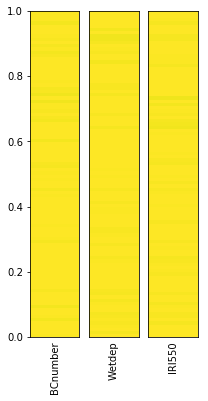

In [14]:
# Note that smoothing the parameter distribution can be slow for large numbers of points
plot_parameter_space(sample_points, fig_size=(3,6), smooth=False)

In [15]:
# Setup the sampler to compare against our AeroNet data
sampler = ABCSampler(model, aaod, obs_uncertainty=0.5, repres_uncertainty=0.5)

100%|##########| 10000/10000 [00:06<00:00, 1676.09sample/s]

[Text(0.5,0,'Implausibility')]

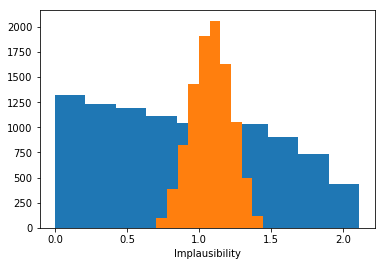

In [16]:
# Calculate the implausibilty for each sample against each observation - note this can be very large so we only sample a fraction!
implaus = sampler.get_implausibility(sample_points[::100], batch_size=1000)

# The implausibility distributions for different observations can be very different.
_ = plt.hist(implaus.data[:, 1400])
_ = plt.hist(implaus.data[:, 14])
plt.gca().set(xlabel='Implausibility')

In [17]:
# Find the valid samples in our full 1million samples by comparing against a given tolerance and threshold
valid_samples = sampler.batch_constrain(sample_points, batch_size=1000, tolerance=.1)
print("Remaining points: {}".format(valid_samples.sum()))

100%|##########| 1000000/1000000 [04:52<00:00, 3503.64sample/s]Remaining points: 723015


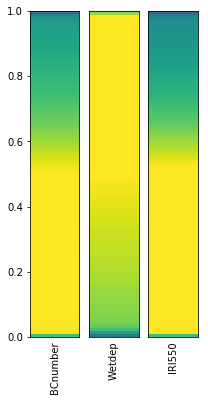

In [18]:
# Plot the reduced parameter distribution
constrained_sample = sample_points[valid_samples]
plot_parameter_space(constrained_sample, fig_size=(3,6))

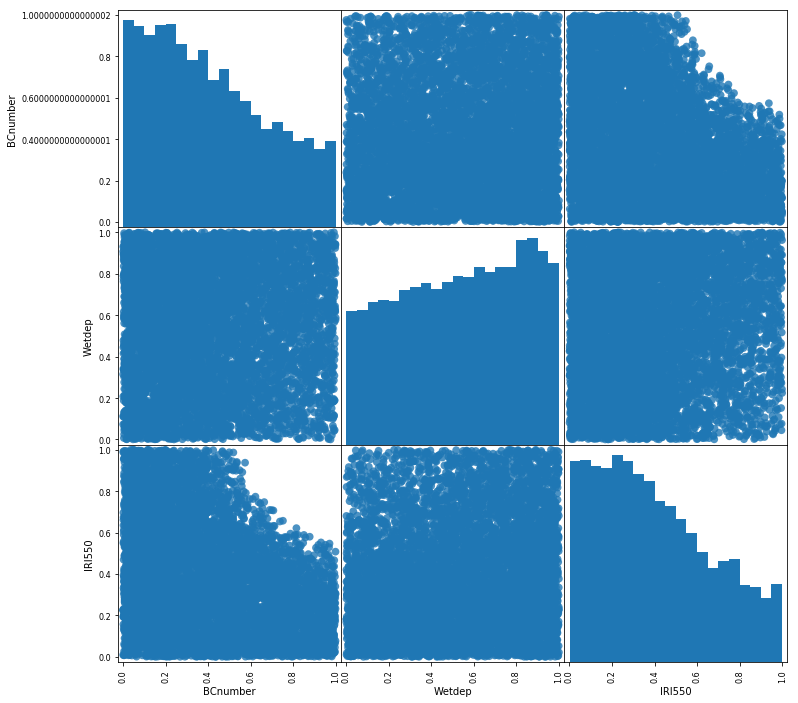

In [19]:
# We can also easily plot the joint distributions
#  Only plot every one in 10 points as scatter plots with large numbers of points are slow...
grr = pd.plotting.scatter_matrix(constrained_sample[::100], figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8, vmin=1e-3, vmax=5e-3)

# Explore the uncertainty in Direct Radiative Effect of Aerosol in constrianed sample-space

In [20]:
dre_test, dre_train = ppe_dre[:n_test], ppe_dre[n_test:]

ari_model = gp_model(X_train, dre_train, "ARI")
ari_model.train()

AttributeError: 'str' object has no attribute 'extend'

In [ ]:
# Calculate the mean and std-dev DRE over each set of sample points

unconstrained_mean_ari, unconstrained_sd_ari = ari_model.batch_stats(sample_points, batch_size=1000)
constrained_mean_ari, constrained_sd_ari = ari_model.batch_stats(constrained_sample, batch_size=1000)

In [ ]:
# The original (unconstrained DRE)
qplt.pcolormesh(unconstrained_sd_ari, vmin=0., vmax=1)
plt.gca().coastlines()

In [ ]:
# The constrained DRE
qplt.pcolormesh(constrained_sd_ari, vmin=0., vmax=1)
plt.gca().coastlines()

In [ ]:
# The change in spread after the constraint is applied
qplt.pcolormesh((constrained_sd_ari-unconstrained_sd_ari), cmap='RdBu_r', vmin=-5e-1, vmax=5e-1)
plt.gca().coastlines()